In [7]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')


print("SAMSARA HOTEL - DASHBOARD VISUALIZATION")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("\n Imports successful!")

SAMSARA HOTEL - DASHBOARD VISUALIZATION

 Imports successful!


In [13]:
print("\n DATABASE")


# Database connection
connection = psycopg2.connect(
    host="localhost",
    port=5432,
    database="samsara_db",
    user="postgres",
    password="201006radithya"
)

query = """
SELECT 
    f.resno,
    f.length_of_stay_days,
    f.lead_time_days,
    f.adults,
    f.children,
    f.room_nights,
    f.total_revenue,
    f.room_rate,
    f.revenue_per_night,
    a.agency_name,
    n.nationality_desc,
    rt.room_type_desc,
    ds.status_id::INTEGER as status_id,
    CASE WHEN ds.status_id::INTEGER = 9 THEN 1 ELSE 0 END as is_cancelled
FROM fact_reservation f
JOIN dim_agency a ON f.agency_key = a.agency_key
JOIN dim_nationality n ON f.nationality_key = n.nationality_key
JOIN dim_room_type rt ON f.room_type_key = rt.room_type_key
JOIN dim_status ds ON f.status_key = ds.status_key
WHERE f.total_revenue > 0
"""

df = pd.read_sql(query, connection)

print(f" Data loaded: {len(df)} rows × {len(df.columns)} columns")
print(f" Columns: {list(df.columns)}")
USD_TO_IDR = 15500
if df['total_revenue'].max() < 100_000:
    df['total_revenue'] = df['total_revenue'] * USD_TO_IDR
    df['room_rate'] = df['room_rate'] * USD_TO_IDR
    df['revenue_per_night'] = df['revenue_per_night'] * USD_TO_IDR
    print(" Currency converted: Dollar → Rupiah")

print(f" Total Revenue: Rp {df['total_revenue'].sum()/1_000_000_000:.1f} Trillion")


 DATABASE
 Data loaded: 2814 rows × 14 columns
 Columns: ['resno', 'length_of_stay_days', 'lead_time_days', 'adults', 'children', 'room_nights', 'total_revenue', 'room_rate', 'revenue_per_night', 'agency_name', 'nationality_desc', 'room_type_desc', 'status_id', 'is_cancelled']
 Total Revenue: Rp 44.9 Trillion


In [14]:
print("\nMODEL RESULTS")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'length_of_stay_days', 'lead_time_days', 'adults', 'children',
    'room_nights', 'total_revenue', 'room_rate', 'revenue_per_night'
]

df_encoded = pd.get_dummies(df, columns=['room_type_desc'], prefix='room_type', drop_first=True)
room_type_cols = [col for col in df_encoded.columns if col.startswith('room_type_')]
feature_cols.extend(room_type_cols)

X = df_encoded[feature_cols].fillna(0)
y = df_encoded['is_cancelled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train models
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Store results
results = {}
models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f" Model: Gradient Boosting (Accuracy: {results['Gradient Boosting']['accuracy']:.2%})")


MODEL RESULTS
 Model: Gradient Boosting (Accuracy: 79.93%)



GENERATING DASHBOARD PAGE 1: EXECUTIVE SUMMARY


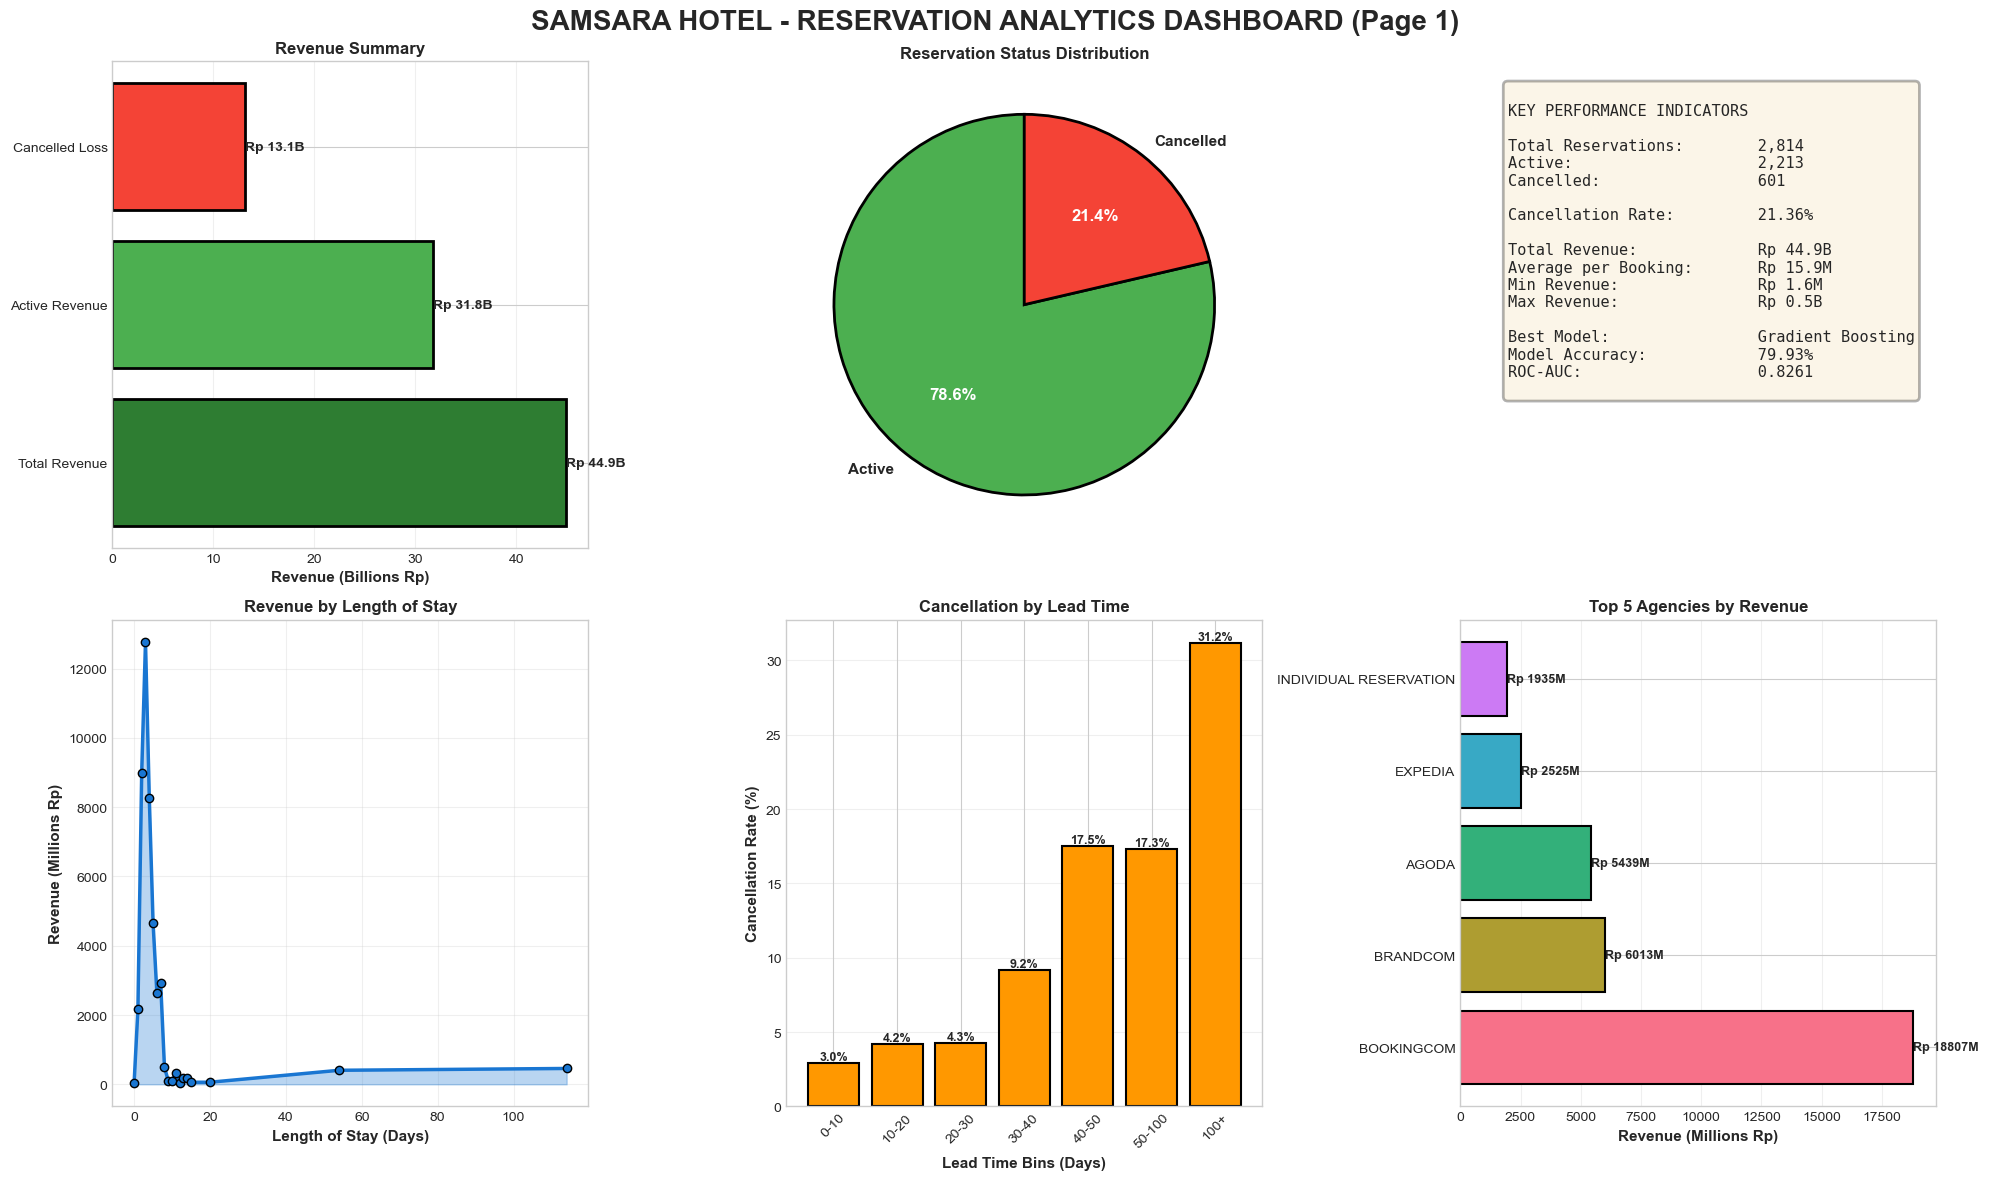

In [10]:
print("\nGENERATING DASHBOARD PAGE 1: EXECUTIVE SUMMARY")

# Currency formatter
def format_idr(x, p):
    if x >= 1_000_000_000:
        return f'Rp {x/1_000_000_000:.1f}B'
    elif x >= 1_000_000:
        return f'Rp {x/1_000_000:.0f}M'
    else:
        return f'Rp {x/1_000:.0f}K'

# Create figure
fig = plt.figure(figsize=(20, 12))
fig.suptitle('SAMSARA HOTEL - RESERVATION ANALYTICS DASHBOARD (Page 1)', 
             fontsize=20, fontweight='bold', y=0.98)

# 1. REVENUE SUMMARY (TOP LEFT)
ax1 = plt.subplot(2, 3, 1)
summary_data = {
    'Total Revenue': df['total_revenue'].sum() / 1_000_000_000,
    'Active Revenue': df[df['is_cancelled']==0]['total_revenue'].sum() / 1_000_000_000,
    'Cancelled Loss': df[df['is_cancelled']==1]['total_revenue'].sum() / 1_000_000_000
}
colors_revenue = ['#2E7D32', '#4CAF50', '#F44336']
bars1 = ax1.barh(list(summary_data.keys()), list(summary_data.values()), 
                  color=colors_revenue, edgecolor='black', linewidth=2)
ax1.set_xlabel('Revenue (Billions Rp)', fontweight='bold', fontsize=11)
ax1.set_title('Revenue Summary', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'Rp {width:.1f}B', 
             ha='left', va='center', fontweight='bold', fontsize=10)

# 2. CANCELLATION DISTRIBUTION (TOP CENTER)
ax2 = plt.subplot(2, 3, 2)
cancel_data = df['is_cancelled'].value_counts()
colors_cancel = ['#4CAF50', '#F44336']
wedges, texts, autotexts = ax2.pie(cancel_data, labels=['Active', 'Cancelled'], 
                                     autopct='%1.1f%%', colors=colors_cancel, startangle=90,
                                     textprops={'fontweight': 'bold', 'fontsize': 11},
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax2.set_title('Reservation Status Distribution', fontweight='bold', fontsize=12)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

# 3. KEY METRICS (TOP RIGHT)
ax3 = plt.subplot(2, 3, 3)
ax3.axis('off')
metrics_text = f"""
KEY PERFORMANCE INDICATORS

Total Reservations:        {len(df):,}
Active:                    {(df['is_cancelled']==0).sum():,}
Cancelled:                 {(df['is_cancelled']==1).sum():,}

Cancellation Rate:         {(df['is_cancelled'].sum()/len(df)*100):.2f}%

Total Revenue:             Rp {df['total_revenue'].sum()/1_000_000_000:.1f}B
Average per Booking:       Rp {df['total_revenue'].mean()/1_000_000:.1f}M
Min Revenue:               Rp {df['total_revenue'].min()/1_000_000:.1f}M
Max Revenue:               Rp {df['total_revenue'].max()/1_000_000_000:.1f}B

Best Model:                Gradient Boosting
Model Accuracy:            {results['Gradient Boosting']['accuracy']:.2%}
ROC-AUC:                   {results['Gradient Boosting']['roc_auc']:.4f}
"""
ax3.text(0.1, 0.95, metrics_text, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3, 
                   edgecolor='black', linewidth=2))

# 4. REVENUE BY LENGTH OF STAY (MIDDLE LEFT)
ax4 = plt.subplot(2, 3, 4)
los_revenue = df.groupby('length_of_stay_days')['total_revenue'].sum() / 1_000_000
ax4.plot(los_revenue.index, los_revenue.values, marker='o', linewidth=2.5, markersize=6, 
         color='#1976D2', markeredgecolor='black', markeredgewidth=1)
ax4.fill_between(los_revenue.index, los_revenue.values, alpha=0.3, color='#1976D2')
ax4.set_xlabel('Length of Stay (Days)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Revenue (Millions Rp)', fontweight='bold', fontsize=11)
ax4.set_title('Revenue by Length of Stay', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3)

# 5. CANCELLATION BY LEAD TIME (MIDDLE CENTER)
ax5 = plt.subplot(2, 3, 5)
lead_time_bins = [0, 10, 20, 30, 40, 50, 100, 200]
df['lead_time_bin'] = pd.cut(df['lead_time_days'], bins=lead_time_bins)
lead_cancel = df.groupby('lead_time_bin')['is_cancelled'].agg(['sum', 'count'])
lead_cancel['cancel_pct'] = (lead_cancel['sum'] / lead_cancel['count'] * 100)

x_pos = range(len(lead_cancel))
bars5 = ax5.bar(x_pos, lead_cancel['cancel_pct'], color='#FF9800', 
                edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Lead Time Bins (Days)', fontweight='bold', fontsize=11)
ax5.set_ylabel('Cancellation Rate (%)', fontweight='bold', fontsize=11)
ax5.set_title('Cancellation by Lead Time', fontweight='bold', fontsize=12)
ax5.set_xticks(x_pos)
ax5.set_xticklabels(['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100+'], rotation=45)
ax5.grid(axis='y', alpha=0.3)
for bar in bars5:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 6. TOP 5 AGENCIES (MIDDLE RIGHT)
ax6 = plt.subplot(2, 3, 6)
top_agencies = df.groupby('agency_name')['total_revenue'].sum().nlargest(5) / 1_000_000
colors_agency = sns.color_palette("husl", len(top_agencies))
bars6 = ax6.barh(range(len(top_agencies)), top_agencies.values, 
                  color=colors_agency, edgecolor='black', linewidth=1.5)
ax6.set_yticks(range(len(top_agencies)))
ax6.set_yticklabels(top_agencies.index, fontsize=10)
ax6.set_xlabel('Revenue (Millions Rp)', fontweight='bold', fontsize=11)
ax6.set_title('Top 5 Agencies by Revenue', fontweight='bold', fontsize=12)
ax6.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars6):
    width = bar.get_width()
    ax6.text(width, bar.get_y() + bar.get_height()/2, 
             f'Rp {width:.0f}M', 
             ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


GENERATING DASHBOARD PAGE 2: MODEL PERFORMANCE


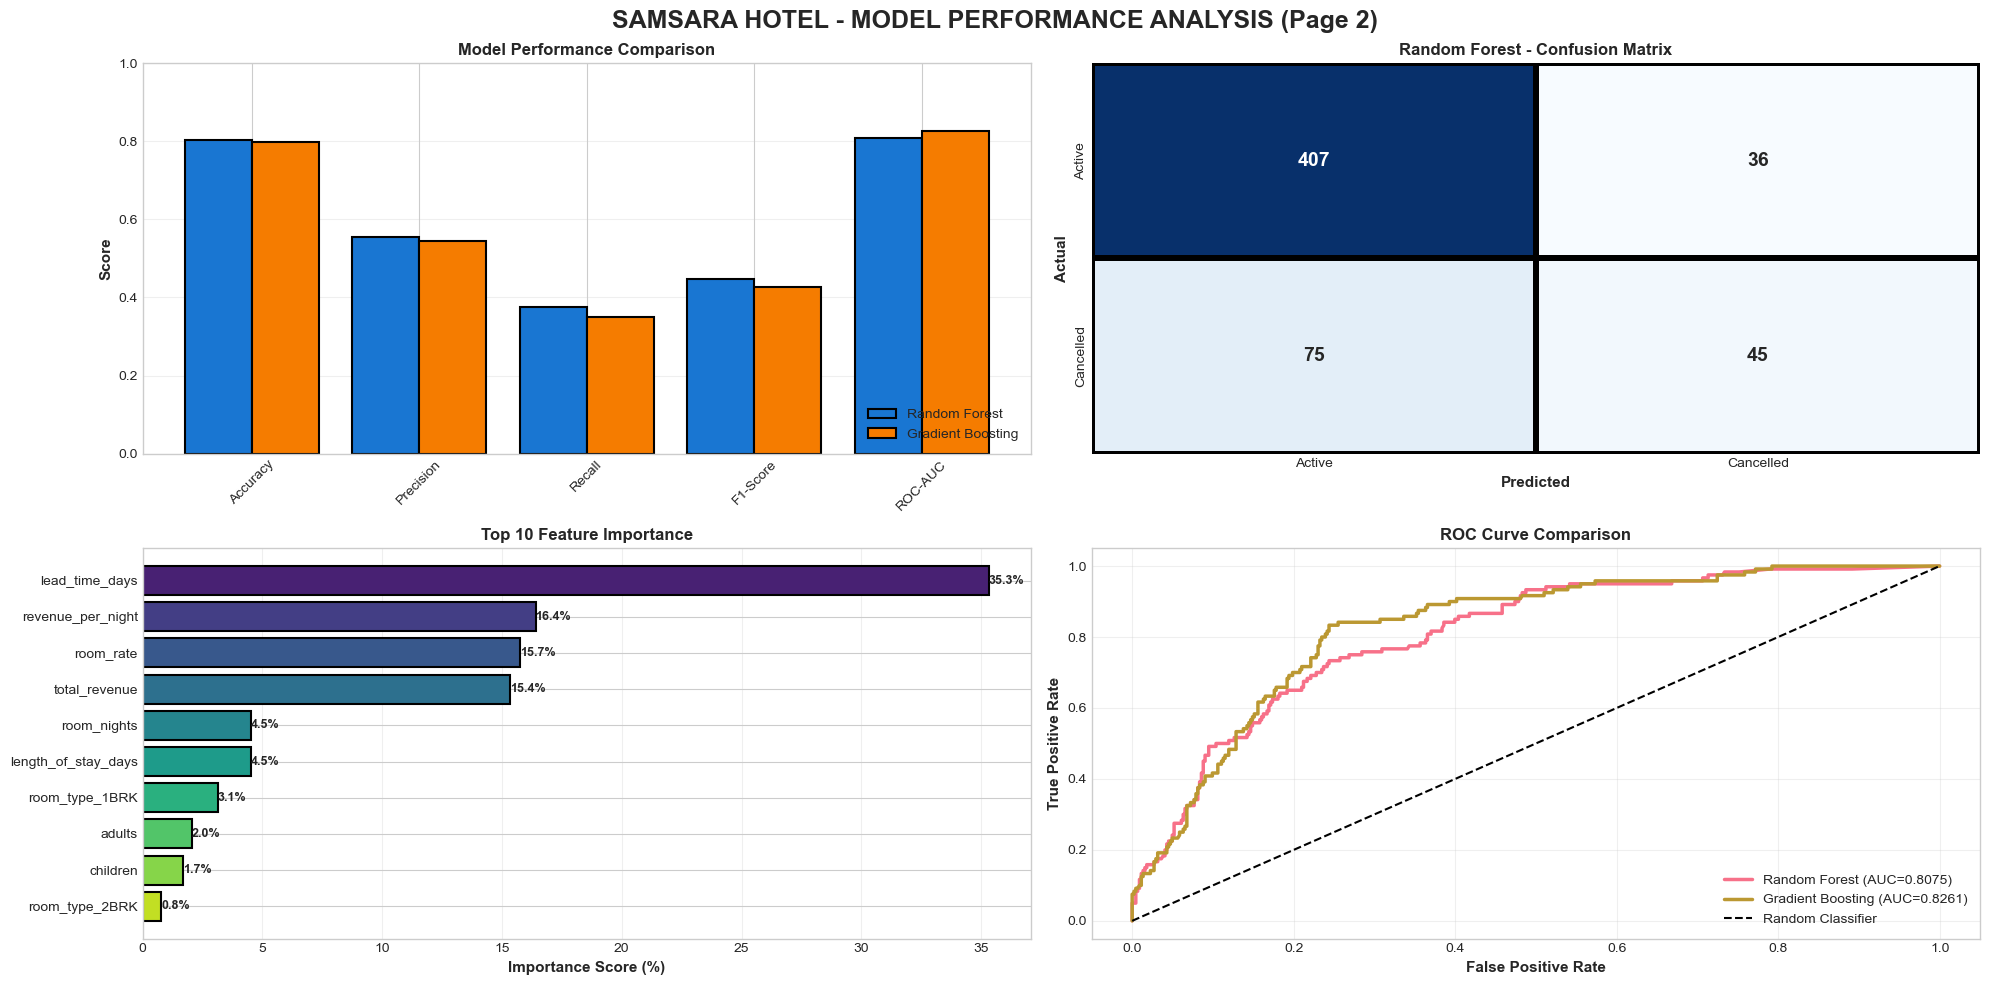

In [11]:
print("\nGENERATING DASHBOARD PAGE 2: MODEL PERFORMANCE")

fig = plt.figure(figsize=(20, 10))
fig.suptitle('SAMSARA HOTEL - MODEL PERFORMANCE ANALYSIS (Page 2)', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. MODEL COMPARISON (LEFT)
ax1 = plt.subplot(2, 2, 1)
models_data = pd.DataFrame({
    'Random Forest': [
        results['Random Forest']['accuracy'],
        results['Random Forest']['precision'],
        results['Random Forest']['recall'],
        results['Random Forest']['f1'],
        results['Random Forest']['roc_auc']
    ],
    'Gradient Boosting': [
        results['Gradient Boosting']['accuracy'],
        results['Gradient Boosting']['precision'],
        results['Gradient Boosting']['recall'],
        results['Gradient Boosting']['f1'],
        results['Gradient Boosting']['roc_auc']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

models_data.plot(kind='bar', ax=ax1, color=['#1976D2', '#F57C00'], 
                 edgecolor='black', linewidth=1.5, width=0.8)
ax1.set_ylabel('Score', fontweight='bold', fontsize=11)
ax1.set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
ax1.set_ylim([0, 1])
# FIX: Use edgecolor instead of frameedgecolor
legend1 = ax1.legend(loc='lower right', fontsize=10, edgecolor='black', fancybox=True)
legend1.get_frame().set_linewidth(2)
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# 2. CONFUSION MATRIX (TOP RIGHT)
ax2 = plt.subplot(2, 2, 2)
cm_rf = confusion_matrix(y_test, results['Random Forest']['y_pred'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False,
            xticklabels=['Active', 'Cancelled'], yticklabels=['Active', 'Cancelled'],
            annot_kws={'size': 14, 'weight': 'bold'}, linewidths=3, linecolor='black')
ax2.set_title('Random Forest - Confusion Matrix', fontweight='bold', fontsize=12)
ax2.set_ylabel('Actual', fontweight='bold', fontsize=11)
ax2.set_xlabel('Predicted', fontweight='bold', fontsize=11)

# 3. FEATURE IMPORTANCE (BOTTOM LEFT)
ax3 = plt.subplot(2, 2, 3)
top_10_features = rf_importance.head(10)
colors_feat = sns.color_palette("viridis", len(top_10_features))
bars3 = ax3.barh(range(len(top_10_features)), top_10_features['importance'].values * 100, 
                  color=colors_feat, edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(top_10_features)))
ax3.set_yticklabels(top_10_features['feature'].values, fontsize=10)
ax3.set_xlabel('Importance Score (%)', fontweight='bold', fontsize=11)
ax3.set_title('Top 10 Feature Importance', fontweight='bold', fontsize=12)
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', 
             ha='left', va='center', fontweight='bold', fontsize=9)

# 4. ROC CURVE (BOTTOM RIGHT)
ax4 = plt.subplot(2, 2, 4)
for model_name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_pred_proba'])
    auc_score = results[model_name]['roc_auc']
    ax4.plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.4f})', linewidth=2.5)

ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)
ax4.set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
ax4.set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
ax4.set_title('ROC Curve Comparison', fontweight='bold', fontsize=12)
# Use edgecolor instead of frameedgecolor
legend4 = ax4.legend(loc='lower right', fontsize=10, edgecolor='black', fancybox=True)
legend4.get_frame().set_linewidth(2)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


GENERATING DASHBOARD PAGE 3: DETAILED ANALYSIS


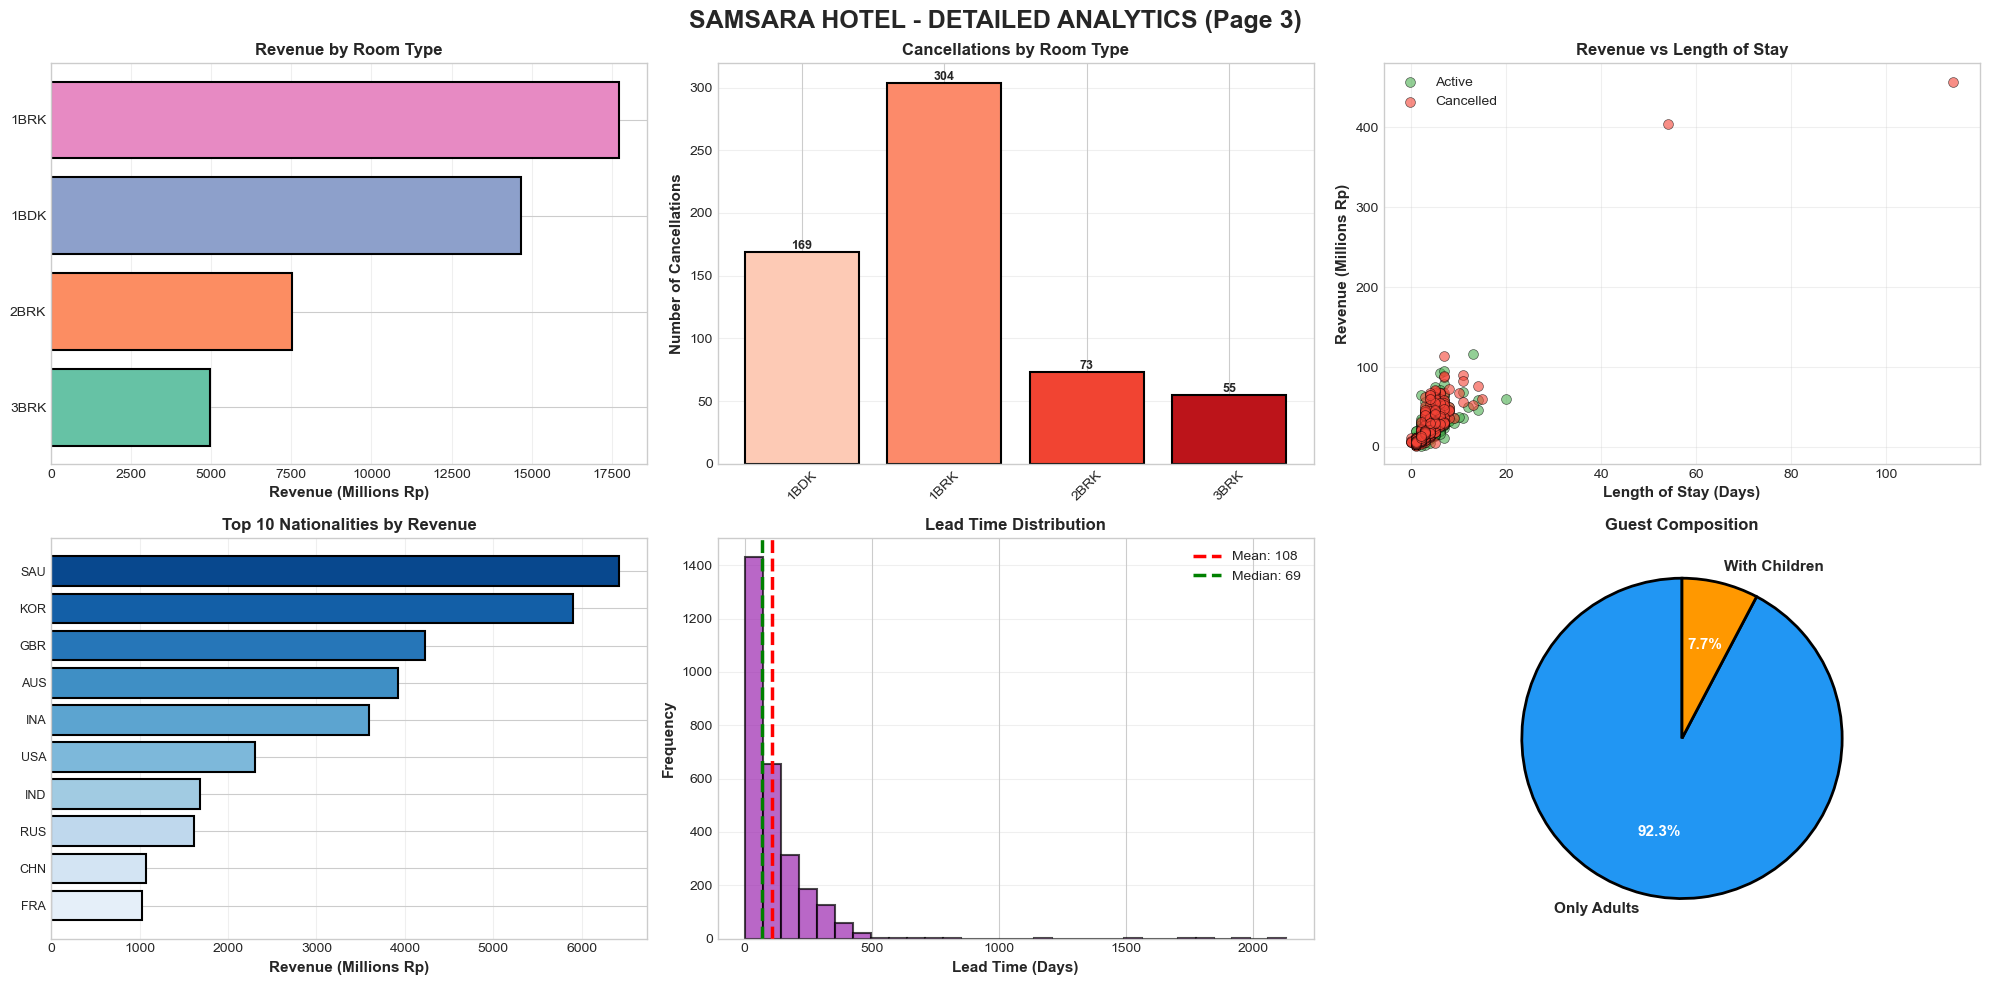

In [12]:
print("\nGENERATING DASHBOARD PAGE 3: DETAILED ANALYSIS")

fig = plt.figure(figsize=(20, 10))
fig.suptitle('SAMSARA HOTEL - DETAILED ANALYTICS (Page 3)', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. REVENUE BY ROOM TYPE (TOP LEFT)
ax1 = plt.subplot(2, 3, 1)
room_revenue = df.groupby('room_type_desc')['total_revenue'].sum().sort_values(ascending=True) / 1_000_000
colors_room = sns.color_palette("Set2", len(room_revenue))
bars1 = ax1.barh(range(len(room_revenue)), room_revenue.values, 
                  color=colors_room, edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(room_revenue)))
ax1.set_yticklabels(room_revenue.index, fontsize=10)
ax1.set_xlabel('Revenue (Millions Rp)', fontweight='bold', fontsize=11)
ax1.set_title('Revenue by Room Type', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# 2. CANCELLATION BY ROOM TYPE (TOP CENTER)
ax2 = plt.subplot(2, 3, 2)
room_cancel = df.groupby('room_type_desc')['is_cancelled'].apply(lambda x: (x==1).sum())
colors_cancel_room = sns.color_palette("Reds", len(room_cancel))
bars2 = ax2.bar(range(len(room_cancel)), room_cancel.values, 
                color=colors_cancel_room, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(room_cancel)))
ax2.set_xticklabels(room_cancel.index, rotation=45, fontsize=10)
ax2.set_ylabel('Number of Cancellations', fontweight='bold', fontsize=11)
ax2.set_title('Cancellations by Room Type', fontweight='bold', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. REVENUE VS LENGTH OF STAY SCATTER (TOP RIGHT)
ax3 = plt.subplot(2, 3, 3)
active_data = df[df['is_cancelled']==0]
cancelled_data = df[df['is_cancelled']==1]
ax3.scatter(active_data['length_of_stay_days'], active_data['total_revenue']/1_000_000, 
           alpha=0.6, s=50, color='#4CAF50', label='Active', edgecolors='black', linewidth=0.5)
ax3.scatter(cancelled_data['length_of_stay_days'], cancelled_data['total_revenue']/1_000_000, 
           alpha=0.6, s=50, color='#F44336', label='Cancelled', edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Length of Stay (Days)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Revenue (Millions Rp)', fontweight='bold', fontsize=11)
ax3.set_title('Revenue vs Length of Stay', fontweight='bold', fontsize=12)
# FIX: Use edgecolor
legend3 = ax3.legend(fontsize=10, edgecolor='black', fancybox=True)
legend3.get_frame().set_linewidth(2)
ax3.grid(alpha=0.3)

# 4. TOP 10 NATIONALITIES (BOTTOM LEFT)
ax4 = plt.subplot(2, 3, 4)
top_nat = df.groupby('nationality_desc')['total_revenue'].sum().nlargest(10).sort_values() / 1_000_000
colors_nat = sns.color_palette("Blues", len(top_nat))
bars4 = ax4.barh(range(len(top_nat)), top_nat.values, color=colors_nat, edgecolor='black', linewidth=1.5)
ax4.set_yticks(range(len(top_nat)))
ax4.set_yticklabels(top_nat.index, fontsize=9)
ax4.set_xlabel('Revenue (Millions Rp)', fontweight='bold', fontsize=11)
ax4.set_title('Top 10 Nationalities by Revenue', fontweight='bold', fontsize=12)
ax4.grid(axis='x', alpha=0.3)

# 5. LEAD TIME DISTRIBUTION (BOTTOM CENTER)
ax5 = plt.subplot(2, 3, 5)
ax5.hist(df['lead_time_days'], bins=30, color='#9C27B0', edgecolor='black', alpha=0.7, linewidth=1.5)
ax5.axvline(df['lead_time_days'].mean(), color='red', linestyle='--', linewidth=2.5, 
            label=f'Mean: {df["lead_time_days"].mean():.0f}')
ax5.axvline(df['lead_time_days'].median(), color='green', linestyle='--', linewidth=2.5, 
            label=f'Median: {df["lead_time_days"].median():.0f}')
ax5.set_xlabel('Lead Time (Days)', fontweight='bold', fontsize=11)
ax5.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax5.set_title('Lead Time Distribution', fontweight='bold', fontsize=12)
# FIX: Use edgecolor
legend5 = ax5.legend(fontsize=10, edgecolor='black', fancybox=True)
legend5.get_frame().set_linewidth(2)
ax5.grid(axis='y', alpha=0.3)

# 6. GUEST COMPOSITION (BOTTOM RIGHT)
ax6 = plt.subplot(2, 3, 6)
composition_data = {
    'Only Adults': len(df[df['children']==0]),
    'With Children': len(df[df['children']>0])
}
colors_comp = ['#2196F3', '#FF9800']
wedges, texts, autotexts = ax6.pie(composition_data.values(), labels=composition_data.keys(), 
                                     autopct='%1.1f%%', colors=colors_comp, startangle=90,
                                     textprops={'fontweight': 'bold', 'fontsize': 11},
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax6.set_title('Guest Composition', fontweight='bold', fontsize=12)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()